# Technical Assessment - Laing O'Rourke

## Submitted by - Aditya Telang

The aim of this notebook is to perform an in-depth Analysis of the UCI Online Retail Dataset (https://archive.ics.uci.edu/ml/datasets/Online+Retail). The data set contains transactional data of a UK-based online retailer that sells unique all occasion gifts to wholesales and end users. The overall goal specifically is to address some of the key questions related to the data, the need and use of EDA, aspects of Feature Engineering, and an appropriate ML-Based Model Analytics

The overall analysis for this assessment is divided into four main tasks: 

1.	Data Pre-processing
2.  Exploratory Data Analysis
3.	Feature Engineering
4.	Model Analytics

Please note that the data used for this analysis is represented in the .csv format (as I had some issues encoding .xlsx file using a MacBook).

## Set Up Python environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings('ignore')

## Task 1 - Data Pre-processing

### Data Import & Inspection

In [2]:
# this line reads .csv files into the script
df = pd.read_csv('Online Retail.csv')

In [3]:
# look at first 10 rows of the dataset 
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01/12/2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01/12/2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01/12/2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01/12/2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01/12/2010 08:34,1.69,13047.0,United Kingdom


Attribute Information:

**InvoiceNo**: Invoice number. **Nominal**, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
<br>
**StockCode**: Product (item) code. **Nominal**, a 5-digit integral number uniquely assigned to each distinct product.
<br>
**Description**: Product (item) name. **Nominal**. 
<br>
**Quantity**: The quantities of each product (item) per transaction. **Numeric**.
<br>
**InvoiceDate**: Invice Date and time. **Numeric**, the day and time when each transaction was generated.
<br>
**UnitPrice**: Unit price. **Numeric**, Product price per unit in sterling.
<br>
**CustomerID**: Customer number. **Nominal**, a 5-digit integral number uniquely assigned to each customer.
<br>
**Country**: Country name. **Nominal**, the name of the country where each customer resides.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Our dataset is composed of 8 columns and **541,909 rows**. 

In [5]:
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print('Number of countries: ', df['Country'].nunique())

Number of transactions:  25900
Number of products bought:  4070
Number of customers: 4372
Number of countries:  38


**Check for Null Values**

In [6]:
## This function counts and creates a dataframe containing the nuber of missing values per column.

# Declare the name of the fuction 
def count_missing(df):
    # creates a dataframe containing the sum of all missing values
    missing_count = pd.DataFrame(df.isnull().sum(),\
                                 # names column "Count" and sorts values in descending order
                                 columns=['Count']).sort_values(by=['Count'],\
                                                                ascending=False)
    return missing_count

#apply the function to the data 
count_missing(df)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [7]:
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print("Percentage of MISSING customers: ", round(df['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )
print("Percentage of MISSING descriptions: ", round(df['Description'].isnull().sum() * 100 / len(df),2),"%" )
print('Number of countries: ', df['Country'].nunique())

Number of transactions:  25900
Number of products bought:  4070
Number of customers: 4372
Percentage of MISSING customers:  24.93 %
Percentage of MISSING descriptions:  0.27 %
Number of countries:  38


1. We are missing values in the CustomerID and Description columns.

2. Nearly 25% of the Customer ID's are missing & we will discard all rows with a missing **Customer ID**. This decision was made because the aim of this project is to explore the data at customer level, therefore all observations that are not assigned to a particular customer cannot be used for analysis.

3. To deal with missing values for **Description**, we will fill each blank description cell with **“Missing”**

### Cleaning the Data

In [8]:
# replace missing descriptions with "Missing"
df["Description"] = df["Description"].fillna("Missing")

In [9]:
#delete all rows with a missing "CustomerID"
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

#check that there aren't any missing values
count_missing(df)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


Assigning data to the right type makes sure that, when performing analysis, calculations are consistent, and data is processed in the right way. 

To check to what type the variables are assigned to by default, we will use the `.info()` function. 
We will format the “InvoiceDate” column to a `datetime` variable, and the “Country” column to a categorical variable.

In [10]:
%%time
#make date format consistent 
df['InvoiceDate']=pd.to_datetime((df['InvoiceDate']))

CPU times: user 1.58 s, sys: 15.3 ms, total: 1.6 s
Wall time: 1.61 s


In [11]:
#make country a categorical variable
df["Country"] = df["Country"].astype('category')

Cancelled orders are the ones whose “InvoiceNo” start with a “C”. Toward that, we create a new binomial variable that indicates whether an order was cancelled or not. The new variable “Cancel” takes the value of 1 if the order was cancelled, or the value of 0 if the order was not cancelled. 

To do so, we create a function named `cancel()` which assigns a value 0 to all rows; however, if the first character of any value in the column "InvoiceNo" is "C", it is assigned a value of 1


In [12]:
%%time
#create a function that will assign 0 to all variables unless the first character of 'InvoiceNo' in 'C'
def cancel(row):
    value = 0
    if row['InvoiceNo'][0] == 'C':
        value = 1
    return value

# Create a new column 'Cancel' to attach to 'data' and set it to the value returned 
  #by the function cancel().
    
# The code 'axis=1' makes the apply function process the dataset by row, 
  #as opposed to by column which is the default option.
df['Cancel'] = df.apply(cancel, axis=1)

# the %%time code returns how much time is needed to run this function.

CPU times: user 31.3 s, sys: 209 ms, total: 31.5 s
Wall time: 31.8 s


In [13]:
#check that there are some cancelled orders and that the new column is in the data
df[df['Cancel']== 1].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel
141,C536379,D,Discount,-1,2010-01-12 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-01-12 09:49:00,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-01-12 10:24:00,1.65,17548.0,United Kingdom,1


## Task 2 - Exploratory Data Analysis (EDA)

### 'Description' Exploration

How many unique "Descriptions" exist?

In [14]:
# general clean up of Description column to remove any heading or trailing white space
df['Description'] = df['Description'].str.strip()
descriptors = pd.unique(df['Description'].values.ravel()).tolist()
print('There are',len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3885 unique descriptors in the Descriptions column.


In [15]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3862 all caps descriptors.


In [16]:
# from inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [17]:
# remove additional erroneous rows
df = df[~df['Description'].isin(additional_problem_list)]

In [18]:
df.describe()

,Quantity,UnitPrice,CustomerID,Cancel
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,0.021889
std,248.693370,69.315162,1713.600303,0.146321
min,-80995.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13953.000000,0.000000
50%,5.000000,1.950000,15152.000000,0.000000
75%,12.000000,3.750000,16791.000000,0.000000
max,80995.000000,38970.000000,18287.000000,1.000000


Notice that there are negative values in the Quantity and UnitPrice columns. I am assuming these are orders that were cancelled and items that were returned, but lets make sure.

### 'InvoiceNo' & 'InvoiceDate' Exploration

As mentioned above, if the Invoice starts with the letter "C", it means that te order was cancelled.

In [19]:
InvoiceNo = pd.unique(df['InvoiceNo'].values.ravel()).tolist()
print('There are', len(InvoiceNo), 'unique invoice numbers in the dataset.')

There are 22190 unique invoice numbers in the dataset.


In [20]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel
141,C536379,D,Discount,-1,2010-01-12 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-01-12 09:49:00,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-01-12 10:24:00,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548.0,United Kingdom,1


In [21]:
cancelled_orders[cancelled_orders['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel


Since we got an empty result set when we filtered the cancelled orders by Quantity > 0, this confirms that the negative values mean the order was cancelled.

**How many orders were cancelled?**

In [22]:
print("There were", len(cancelled_orders), "cancelled orders.")

#Calculate the percentage of cancellations by dividing the cancelled orders by the total orders
total_orders = df['InvoiceNo'].nunique()
number_cancelled = len(cancelled_orders)
print('Percentage of orders cancelled: {:.2f}% '.format(number_cancelled *100 / total_orders ))

There were 8905 cancelled orders.
Percentage of orders cancelled: 40.13% 


9288 or about 36% of the orders were cancelled. Looking deeper into why these orders were cancelled may prevent future cancellations.

 Now let's find out what a negative UnitPrice means.

In [23]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel


The description of "Adjust bad debt" tells us that this is an adjustment for a customer with insufficient funds or an allowance for a customer who never paid for the order.

In [24]:
timestamp_list = list(df.InvoiceDate)

Timeframe = pd.DataFrame(pd.to_datetime(timestamp_list), columns=['time'])

In [25]:
df['time'] = Timeframe['time'].values
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,0,2010-01-12 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,0,2010-01-12 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00


Invoice numbers increase in September and October and peak in November, possibly attributed to Christmas shopping.

### 'Orders' Exploration

**a. What's the total number of orders per customer?**

In [26]:
#Find the unique number of InvoiceNo  per customer
groupby_customers = pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].count())
groupby_customers.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17


**a. What's the average number of orders per customer?**

In [27]:
#Find the unique number of InvoiceNo  per customer
groupby_cus = pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].nunique())
groupby_cus.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [28]:
groupby_cus.describe()

,InvoiceNo
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


The average number of orders per customer is 5.
<br>
<br>
We found in descriptive statistics above that customers buy an average quantity of about 10 per product. Are there some products that are extremely popular? What's the distribution of the number of items the customers buy?

#### b. What's the average number of unqiue items per order and per customer?

In [29]:
groupby_invoice = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of Items per Order']
groupby_invoice.head()

,Number of Items per Order
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [30]:
groupby_invoice.describe()

,Number of Items per Order
count,22190.000000
mean,17.876566
std,22.872614
min,1.000000
25%,3.000000
50%,12.000000
75%,24.000000
max,541.000000


Let's see how this compares to the number of unique products per customer.

In [31]:
groupby_ID = pd.DataFrame(df.groupby('CustomerID')['StockCode'].nunique())
groupby_ID.columns = ['Number of Items per Customer']
groupby_ID.head()

,Number of Items per Customer
CustomerID,
12346.0,1
12347.0,103
12348.0,22
12349.0,73
12350.0,17


In [32]:
groupby_ID.describe()

,Number of Items per Customer
count,4372.000000
mean,61.211116
std,85.425119
min,1.000000
25%,15.000000
50%,35.000000
75%,77.000000
max,1794.000000


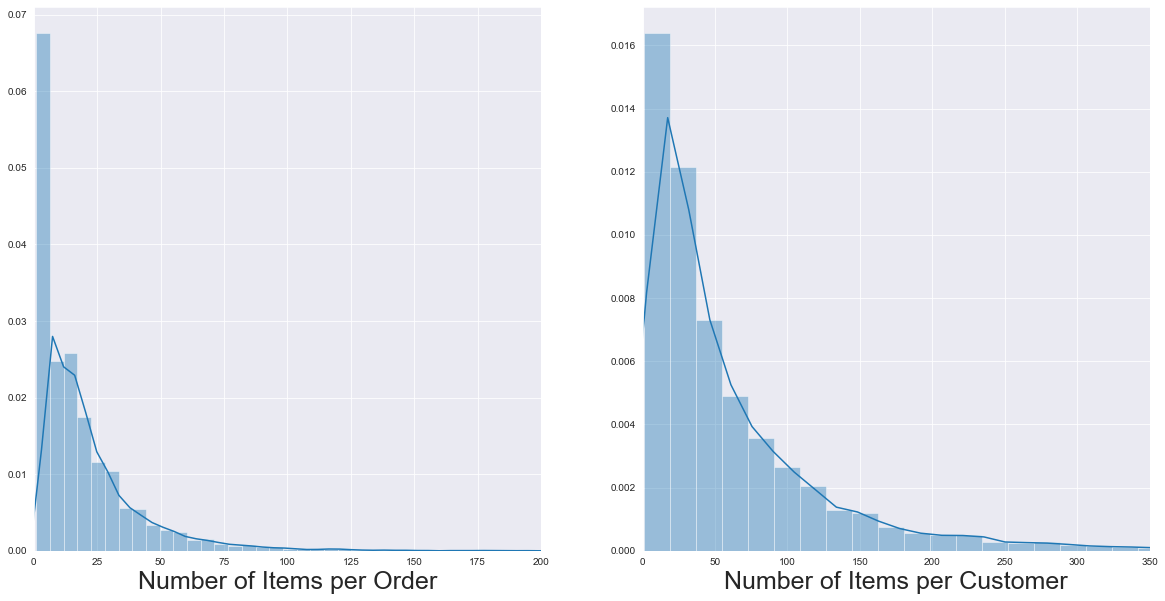

In [33]:
#Visualize the distribution of both
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)
plt1 = sns.distplot(groupby_invoice['Number of Items per Order'], ax=ax[0], bins=100)
plt1.set_xlim(0,200)
plt1.set_xlabel(xlabel='Number of Items per Order',fontsize=25)
plt2 = sns.distplot(groupby_ID['Number of Items per Customer'], ax=ax[1], bins=100)
plt2.set_xlim(0,350)
plt2.set_xlabel(xlabel='Number of Items per Customer',fontsize=25)
plt.show()

We have skewed left distributions for both plots. The average number of items per order is 18 and the average number of items per customer is 61.

**c. How long has the customer been purchasing for?**

In [34]:
#### Create a varible that shows how much time a person has been a customer.

#group by customerID and select the mininum date (i.e. the date at which the first order was placed)
#as_index=false means that customer ID is a column and not the index
days= df.groupby('CustomerID', as_index=False)['InvoiceDate'].min()

#edit names of columns 
days.columns = ['CustomerID', 'Earliest_Invoice']

#create a column with the date of the latest order placed
days['Latest_Invoice'] = pd.to_datetime((df['InvoiceDate']).max())
days.set_index('CustomerID')
days.head(3)

,CustomerID,Earliest_Invoice,Latest_Invoice
0,12346.0,2011-01-18 10:01:00,2011-12-10 17:19:00
1,12347.0,2010-07-12 14:57:00,2011-12-10 17:19:00
2,12348.0,2010-12-16 19:09:00,2011-12-10 17:19:00


In [35]:
#calculate how many days the person has been a customer by subtracting the date of the latest invoice
# to the date of the first invoice
days['days_as_customer'] = 1 + (days.Latest_Invoice-days.Earliest_Invoice).astype('timedelta64[D]')

#delete earliest invoice and laterst invoice columns
days.drop(['Earliest_Invoice', 'Latest_Invoice'], axis=1, inplace=True)
days.head()

,CustomerID,days_as_customer
0,12346.0,327.0
1,12347.0,517.0
2,12348.0,359.0
3,12349.0,20.0
4,12350.0,312.0


**c. Does the customer purchase expensive or cheap items?**

In [36]:
#group by 'customerID' and average unitprice to see if the person buys expensive items or not
groupby_price = df.groupby('CustomerID')['UnitPrice'].mean()
groupby_price.head(3)

CustomerID
12346.0    1.040000
12347.0    2.644011
12348.0    5.764839
Name: UnitPrice, dtype: float64

**e. Where does the customer typically belong to?**

In [37]:
#grouped data by customerID and pasted the value of 'Country' 
groupby_country = df.groupby('CustomerID')['Country'].first()
groupby_country.head(3)

CustomerID
12346.0    United Kingdom
12347.0           Iceland
12348.0           Finland
Name: Country, dtype: object

### 'Country' Exploration

In [38]:
by_country = df.groupby('Country')
by_country.describe()

Quantity                                               \
                         count       mean         std      min    25%   50%   
Country                                                                       
Australia               1259.0  66.444003   97.686932   -120.0   6.00  24.0   
Austria                  401.0  12.037406   21.745485    -48.0   6.00   9.0   
Bahrain                   17.0  15.294118   24.959379      2.0   6.00   6.0   
Belgium                 2069.0  11.189947   13.601441    -12.0   4.00  10.0   
Brazil                    32.0  11.125000    8.476723      2.0   3.00  10.0   
Canada                   151.0  18.298013   46.682587      1.0   6.00  12.0   
Channel Islands          758.0  12.505277   22.570877     -2.0   4.00  10.0   
Cyprus                   622.0  10.155949   23.263590    -33.0   2.00   5.0   
Czech Republic            30.0  19.733333   22.813990    -24.0  12.00  24.0   
Denmark                  389.0  21.048843   27.402502    -25.0  12.00  12.0   
EIRE                    7485.0  18.213627   42.025703   -288.0   4.00  10.0   
European Community        61.0   8.147541    6.546847     -2.0   3.00   6.0   
Finland                  695.0  15.346763   21.001421    -27.0   6.00  10.0   
France                  8491.0  12.936992   21.459204   -250.0   5.00  10.0   
Germany                 9495.0  12.369458   17.865719   -288.0   5.00  10.0   
Greece                   146.0  10.657534    7.724067     -1.0   5.25  10.0   
Iceland                  182.0  13.505495   18.856172      2.0   6.00  12.0   
Israel                   250.0  15.960000   16.730512    -32.0   4.00  12.0   
Italy                    803.0   9.961395   13.579809    -12.0   4.00   6.0   
Japan                    358.0  70.441341  177.191079   -624.0   4.00  36.0   
Lebanon                   45.0   8.577778    4.314294      2.0   6.00   8.0   
Lithuania                 35.0  18.628571   10.137542      6.0  12.00  16.0   
Malta                    127.0   7.433071    8.069726     -4.0   3.00   6.0   
Netherlands             2371.0  84.406580  111.369151   -480.0  16.00  72.0   
Norway                  1086.0  17.722836   22.644876    -12.0   6.00  12.0   
Poland                   341.0  10.712610   10.174628     -6.0   4.00  10.0   
Portugal                1480.0  10.840541   11.914967    -12.0   3.75  10.0   
RSA                       58.0   6.068966    3.329096      1.0   3.00   6.0   
Saudi Arabia              10.0   7.500000    5.720334     -5.0   6.00   9.0   
Singapore                229.0  22.855895   27.742886     -1.0   8.00  12.0   
Spain                   2533.0  10.589814   24.130396   -288.0   3.00   6.0   
Sweden                   462.0  77.136364  128.891540   -240.0   8.00  20.0   
Switzerland             1877.0  15.864678   19.293265   -120.0   6.00  12.0   
USA                      291.0   3.553265   16.450545    -36.0 -10.00   5.0   
United Arab Emirates      68.0  14.441176   12.474909      1.0   6.00  12.0   
United Kingdom        361878.0  11.077029  263.129266 -80995.0   2.00   4.0   
Unspecified              244.0   7.331967    8.895856      1.0   1.00   2.0   

                                     UnitPrice              ... CustomerID  \
                        75%      max     count        mean  ...        75%   
Country                                                     ...              
Australia              96.0   1152.0    1259.0    3.220612  ...   12415.00   
Austria                12.0    288.0     401.0    4.243192  ...   12818.00   
Bahrain                 8.0     96.0      17.0    4.644118  ...   12355.00   
Belgium                12.0    272.0    2069.0    3.644335  ...   12431.00   
Brazil                 18.0     24.0      32.0    4.456250  ...   12769.00   
Canada                 20.0    504.0     151.0    6.030331  ...   17444.00   
Channel Islands        12.0    407.0     758.0    4.932124  ...   14936.00   
Cyprus                 12.0    288.0     622.0    6.302363  ...   12391.00   
Cze

**a. What's the order distribution per country?**

Let's look at the number of customers by country to get an idea of which countries have the most orders.

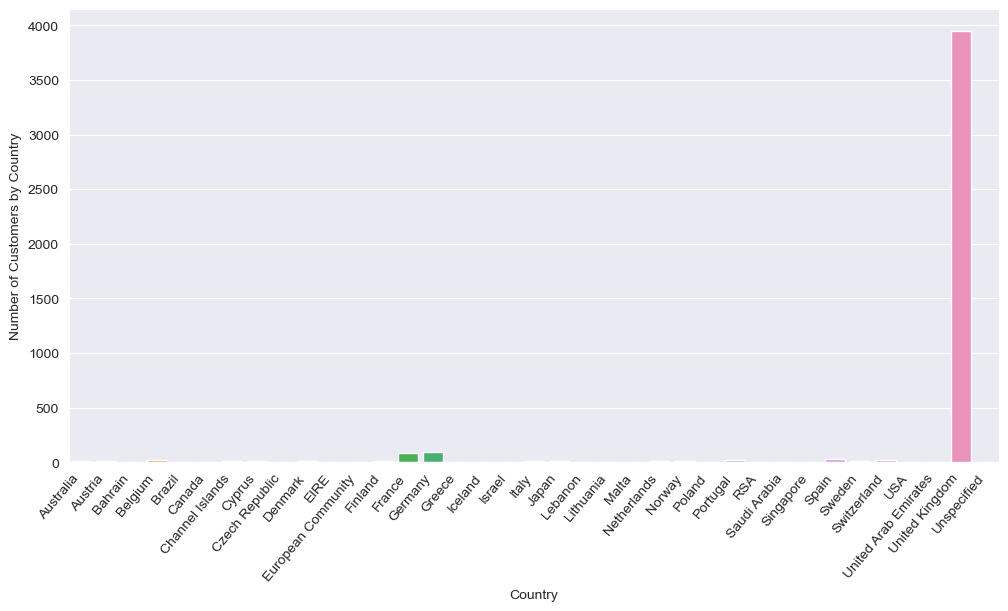

In [39]:
country_df = pd.DataFrame(df.groupby('Country')['CustomerID'].nunique())
country_df.columns = ['Number of Customers by Country']
country_df.sort_values('Number of Customers by Country', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(12,6),dpi=100)
ax=sns.barplot(x=country_df.index, y=country_df['Number of Customers by Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

## Task 3 -  Feature engineering

Moving on from exploratory data analysis, are there any features that can be created in order to categorize/cluster aspects of the data and aid machine learning?

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,0,2010-01-12 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,0,2010-01-12 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00


**a. Investigating the total amount spent per customer**

In [41]:
df['Total_Cost'] = df['Quantity'] * df['UnitPrice']

In [42]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,time,Total_Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,0,2010-01-12 08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,0,2010-01-12 08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,0,2010-01-12 08:26:00,20.34


**b. How much is the total spending per transaction for a customer?**

In [43]:
#group dataset by cystomerID to start creating customer profiles. 
#The following code groups the data by customerID and sum quantity, transaction spending, and number of cancelled orders
groupby_transc=df.groupby('CustomerID')['Quantity','Total_Cost', 'Cancel'].sum()
groupby_transc.head(3)

,Quantity,Total_Cost,Cancel
CustomerID,,,
12346.0,0,0.00,1
12347.0,2458,4310.00,0
12348.0,2341,1797.24,0


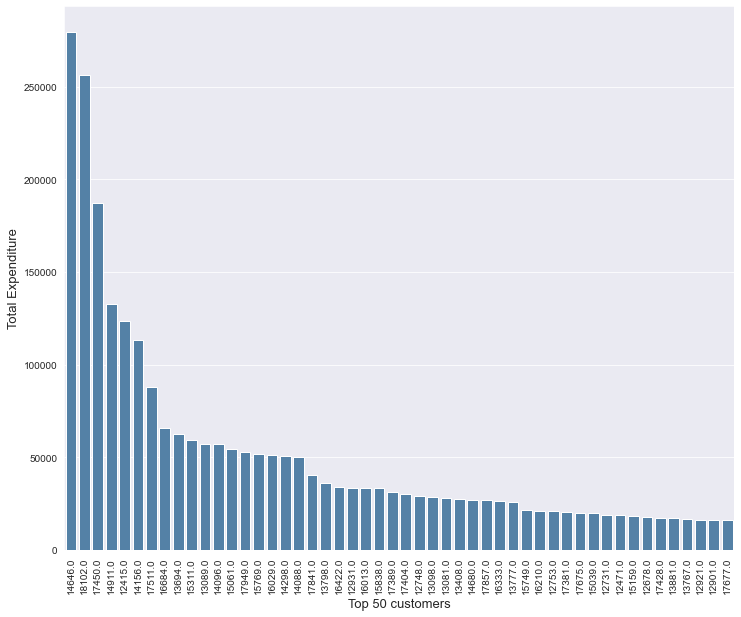

In [44]:
grouped  = df.groupby(['CustomerID']).sum()['Total_Cost'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['Total_Cost'],order=grouped_top['CustomerID'],color='steelblue')
plt.ylabel('Total Expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()


**b. Calculate the top 50 largest baskets, in terms of total spend**

In [45]:
c1_tmp = pd.DataFrame(cancelled_orders['InvoiceNo'])
c2_tmp = cancelled_orders['InvoiceNo'].str.extract('(\d+)').astype(int)
c1_tmp['invoice2'] = c2_tmp

In [46]:
df1 = df
df1 = df1[~df['InvoiceNo'].isin(c1_tmp['InvoiceNo'])]
df1 = df1[~df['InvoiceNo'].isin(c1_tmp['invoice2'])]

In [47]:
top_50 = df1[df1['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,time,Total_Cost
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-01-12 09:41:00,4.25,15311.0,United Kingdom,0,2010-01-12 09:41:00,97.75
107,536381,84854,GIRLY PINK TOOL SET,5,2010-01-12 09:41:00,4.95,15311.0,United Kingdom,0,2010-01-12 09:41:00,24.75
108,536381,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2010-01-12 09:41:00,1.95,15311.0,United Kingdom,0,2010-01-12 09:41:00,19.50
109,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,2010-01-12 09:41:00,2.10,15311.0,United Kingdom,0,2010-01-12 09:41:00,4.20
110,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,2010-01-12 09:41:00,1.25,15311.0,United Kingdom,0,2010-01-12 09:41:00,7.50


**c. Classify customers based on total cost**

Collate all the purchases made during a single order to calculate the total order value:

In [48]:
temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Total_Cost'].sum()
basket_price = temp.rename(columns = {'Total_Cost':'Basket value'})

In [49]:
# top 10 baskets
basket_price.head(10)

,CustomerID,InvoiceNo,Basket value
0,12346.0,541431,77183.60
1,12347.0,537626,711.79
2,12347.0,542237,475.39
3,12347.0,549222,636.25
4,12347.0,556201,382.52
5,12347.0,562032,584.91
6,12347.0,573511,1294.32
7,12347.0,581180,224.82
8,12348.0,539318,892.80
9,12348.0,541998,227.44


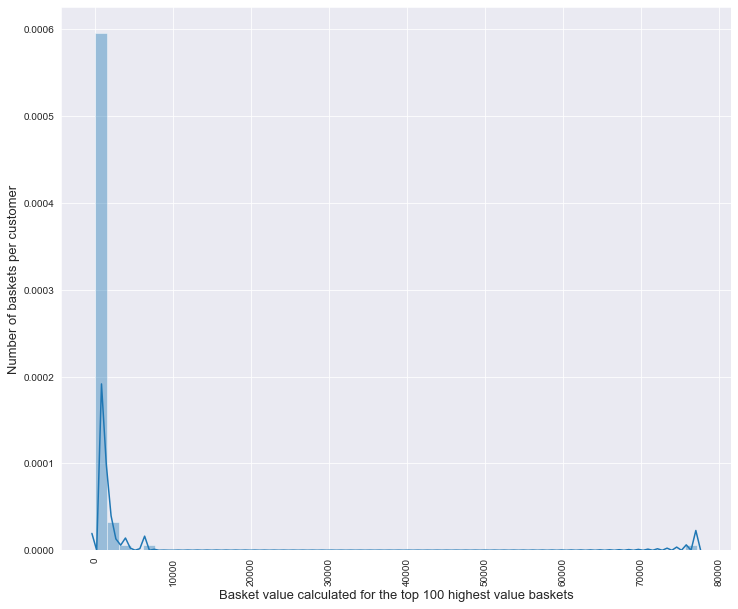

In [50]:
tmp = basket_price
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.sort_values('Basket value', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.distplot(tmp['Basket value'][:100])
plt.ylabel('Number of baskets per customer', fontsize=13)
plt.xlabel('Basket value calculated for the top 100 highest value baskets', fontsize=13)
plt.show()

**d. Investigating the total amount spent per country**

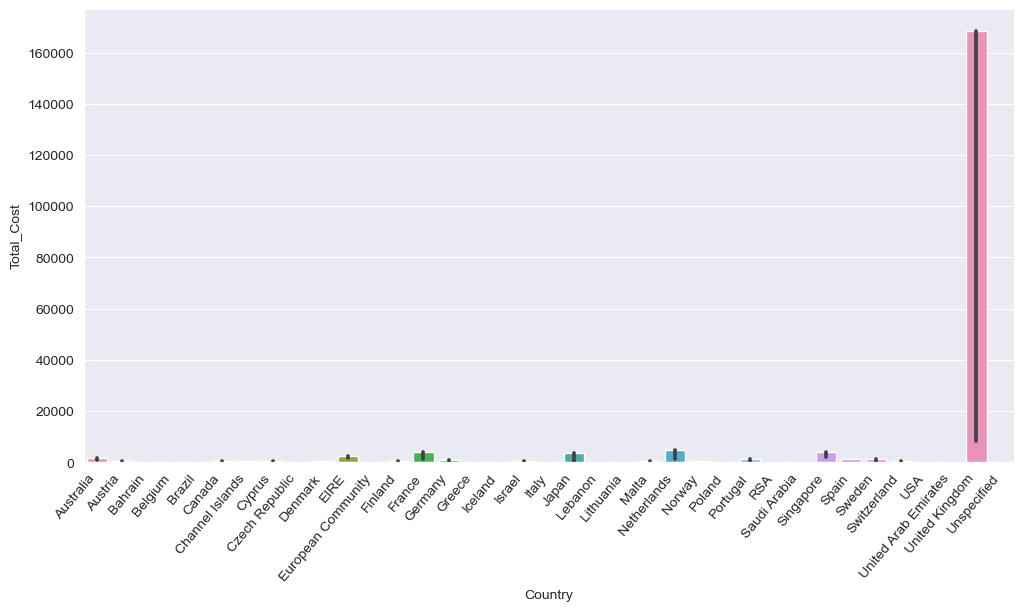

In [51]:
fig1, ax1 = plt.subplots(figsize=(12,6),dpi=100)
ax1=sns.barplot(x='Country', y='Total_Cost', data=df, estimator=max, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50, ha="right")
plt.show()

* The UK not only has the most sales revenue, but also the most customers. 
* Since the majority of this data set contains orders from the UK, we can explore the UK market further by finding out what products the customers buy together and any other buying behaviors to improve our sales and targeting strategy.

### 'UK Market' Exploration

In [52]:
df_uk = df[df['Country']=='United Kingdom']
df_uk.describe()

,Quantity,UnitPrice,CustomerID,Cancel,Total_Cost
count,361878.000000,361878.000000,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368,0.020816,18.702086
std,263.129266,70.654731,1594.402590,0.142770,451.918484
min,-80995.000000,0.000000,12346.000000,0.000000,-168469.600000
25%,2.000000,1.250000,14194.000000,0.000000,3.750000
50%,4.000000,1.950000,15514.000000,0.000000,10.200000
75%,12.000000,3.750000,16931.000000,0.000000,17.700000
max,80995.000000,38970.000000,18287.000000,1.000000,168469.600000


In [53]:
print("Percentage of customers from the UK: ", round(df_uk['CustomerID'].nunique() * 100 / df['CustomerID'].nunique(),2),"%" )
print("Number of transactions: ", df_uk['InvoiceNo'].nunique())
print("Number of products Bought: ", df_uk['StockCode'].nunique())
print("Number of customers:", df_uk['CustomerID'].nunique())

Percentage of customers from the UK:  90.35 %
Number of transactions:  19857
Number of products Bought:  3661
Number of customers: 3950


**What are the most popular products that are bought in the UK?**

In [54]:
uk_product = df_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
3007,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,47982
3437,85099B,JUMBO BAG RED RETROSPOT,40880
3266,84879,ASSORTED COLOUR BIRD ORNAMENT,32679
3452,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32097
1105,22197,POPCORN HOLDER,28562
1500,22616,PACK OF 12 LONDON TISSUES,24313
77,17003,BROCADE RING PURSE,22708
429,21212,PACK OF 72 RETROSPOT CAKE CASES,22205
1085,22178,VICTORIAN GLASS HANGING T-LIGHT,21456
924,21977,PACK OF 60 PINK PAISLEY CAKE CASES,19916


As part of our analysis, we will focus on the UK segment in particular

* In the period between 01/12/2010 and 09/12/2011 the website served 7000+ customers. 
* Additionally, even though the website sells internationally, the majority of their customers placed orders from the United Kingdom. 
* This could be due to high international shipping fees or poor marketing presence in foreign countries. 
* International expansion could be an opportunity of profit for the company.

### Merging the above analysis into a single dataset for focussed analysis

In [55]:
groupby_transc=df.groupby('CustomerID')['Quantity','Total_Cost', 'Cancel'].sum()

groupby_transc.head(3)

,Quantity,Total_Cost,Cancel
CustomerID,,,
12346.0,0,0.00,1
12347.0,2458,4310.00,0
12348.0,2341,1797.24,0


In [56]:
# create list of datafames to join that have the same index
to_join=[groupby_customers, groupby_country, groupby_price]
# use join() to join aggQ with the three dataframes listed above
joined = groupby_transc.join(to_join)

joined = joined.join(days.set_index('CustomerID'))

# edit column names
joined.columns = ['total_quantity', 'total_spending','total_cancelled_orders', \
                  'total_orders_placed','country_of_origin', 'average_price_of_items', 'days_as_customer']


In [57]:
#delete all negative values
joined = joined.drop(joined[(joined.total_quantity < 0)].index)
joined = joined.drop(joined[(joined.total_spending < 0)].index)

The new dataset contains the following variables:
- CustomerID: customer unique identifier
- total_quantity: total number of items purchased by customer
- total_spending: total amount spent by the customer
- total_cancelled_orders: total number of orders cancelled by the customer
- total_orders_placed: total number of orders placed by the customer
- country_of_origin: country of origin of the customer
- average_price_of_items: average price of items purchased
- days_as_customer: days between first and last orders placed by the customer

In [58]:
joined.head(10)

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,country_of_origin,average_price_of_items,days_as_customer
CustomerID,,,,,,,
12346.0,0,0.00,1,2,United Kingdom,1.040000,327.0
12347.0,2458,4310.00,0,182,Iceland,2.644011,517.0
12348.0,2341,1797.24,0,31,Finland,5.764839,359.0
12349.0,631,1757.55,0,73,Italy,8.289041,20.0
12350.0,197,334.40,0,17,Norway,3.841176,312.0
12352.0,470,1545.41,10,95,Norway,23.274737,342.0
12353.0,20,89.00,0,4,Bahrain,6.075000,205.0
12354.0,530,1079.40,0,58,Spain,4.503793,234.0
12355.0,240,459.40,0,13,Bahrain,4.203846,97.0


### Understanding Data Visually

To explore the relationships betweeen the variables of the dataset I ran the `sns.pairplot()` function which plot pairwise relationships in a dataset.

By default, `sns.pairplot()` only plot numerical columns, however I have used the categorical variable "country_of_origin" to color code the plots. The fuction generates two basic figures, histograms and scatter plots. The histograms on the diagonal show us the distribution of a single variable, while the scatter plots show us the relationship between a pair of variables (Koehrsen, 2018). 

In this case, the pairplot is showing us that the variable "days_as_customer" is the only containing varied values, and that the most visible positive relationship between a pair of variables is between "total_quantity" and "total_spending". In fact, as expected, as the quantity purchased increases, the total spending also increases. Moreover, the colors of the plot, show us that the majority of customers are from the UK.  

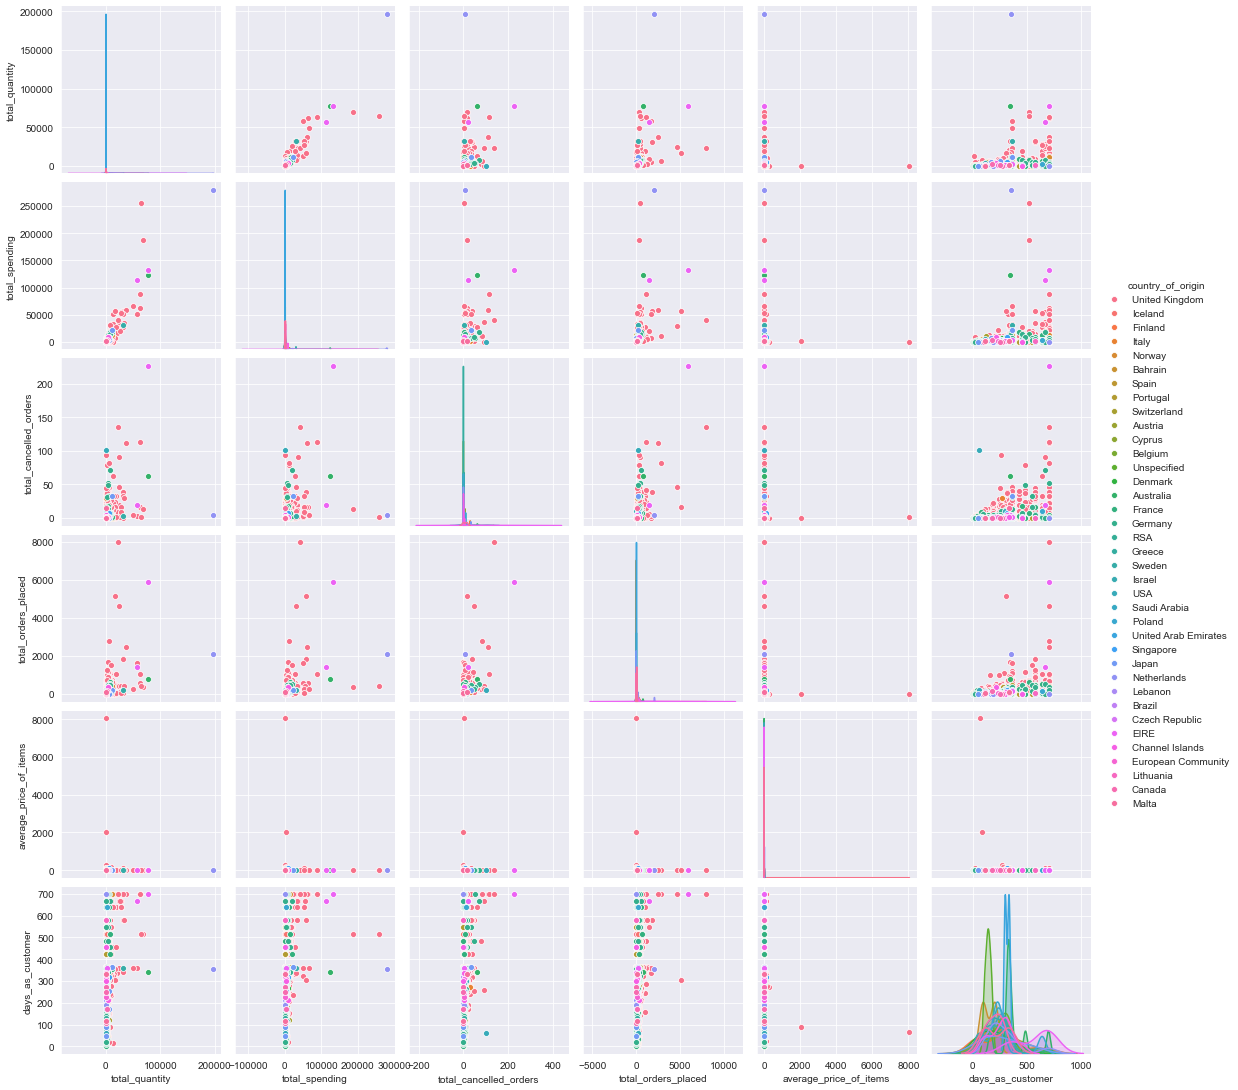

In [59]:
#pairplot gives you a scattered plot of all pairs of variables. 
# hue = country of origin colors each observation differently depending 
  # on their country of origin 
sns.pairplot(joined, kind='scatter', hue= 'country_of_origin');

Since we are comparing variables measured with different units, for example, "total_quantity" is expressed in number of orders while "total_spending" is expressed in GBP, I have decided to scale the dataset, and run `sns.pairplot()` on the scaled dataset to see if any difference can be observed.

Scaling or standardising a dataset means subtracting the mean and dividing by the standard deviation each observation. This gives all variables the properties of a standard normal distribution with **μ=0** and **σ=1**.

In [60]:
# scale dataset

#select numerical variables to scale
num_cols= ['total_quantity', 'total_spending',\
           'total_cancelled_orders', 'total_orders_placed',\
           'average_price_of_items', 'days_as_customer']

#subset dataset to contain only numerical variables
joined_toscale = joined[num_cols]

#scale dataset
joined_scaled = pd.DataFrame(preprocessing.scale(joined_toscale),
                           index=joined_toscale.index,
                           columns=joined_toscale.columns)

#add country of origin variable for coloring of pairplot
joined_scaled["country_of_origin"]= joined["country_of_origin"]
joined_scaled.head()

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer,country_of_origin
CustomerID,,,,,,,
12346.0,-0.241593,-0.232636,-0.138209,-0.393813,-0.039807,0.338152,United Kingdom
12347.0,0.282003,0.289361,-0.274125,0.377212,-0.027119,1.512968,Iceland
12348.0,0.257080,-0.014967,-0.274125,-0.269592,-0.002433,0.536016,Finland
12349.0,-0.107179,-0.019774,-0.274125,-0.089687,0.017533,-1.560102,Italy
12350.0,-0.199628,-0.192136,-0.274125,-0.329561,-0.017650,0.245404,Norway


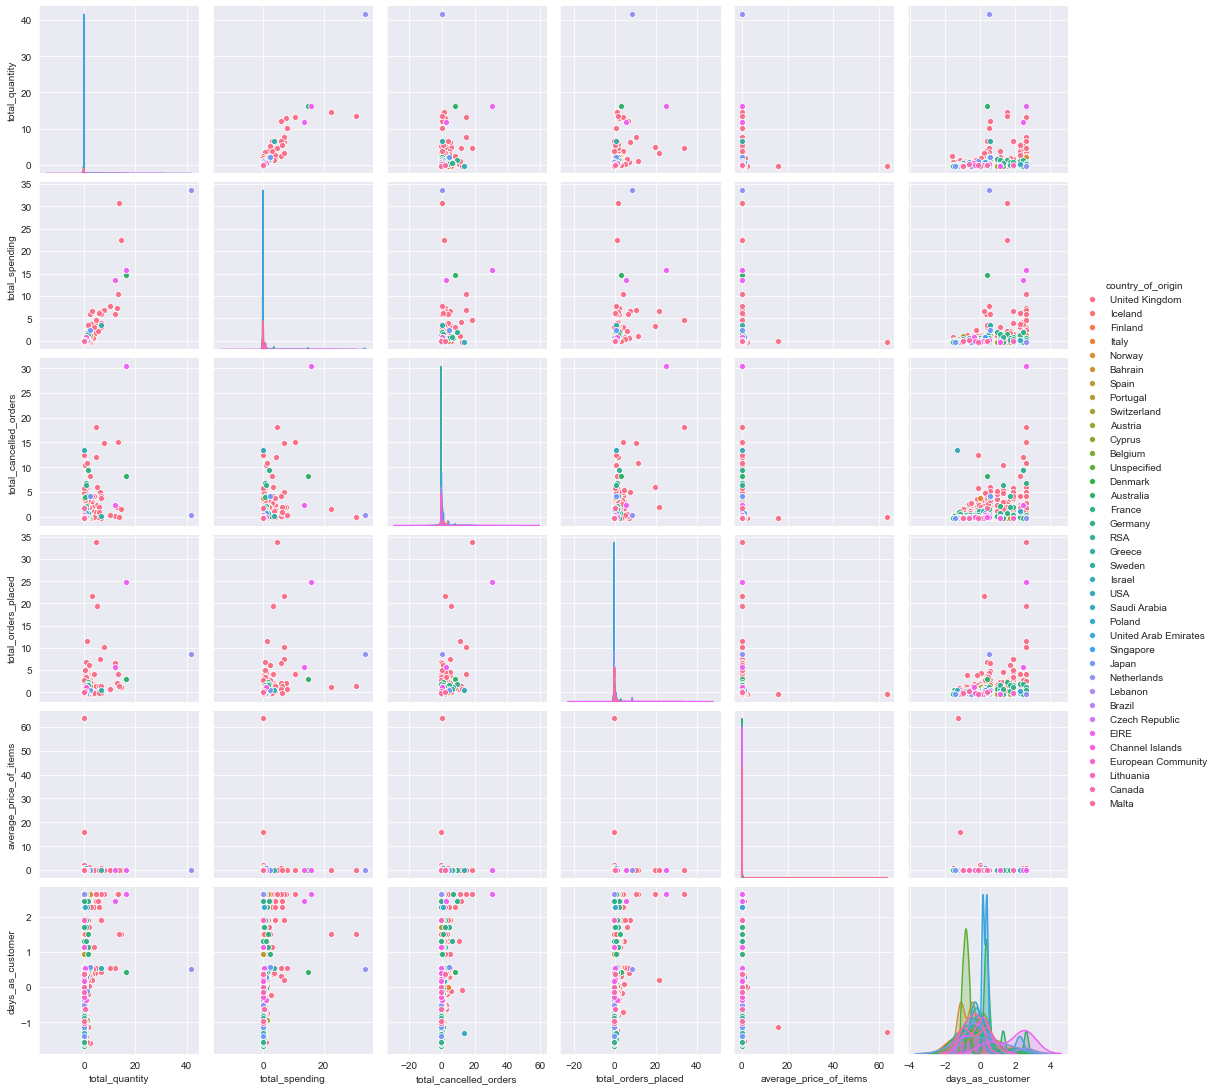

In [61]:
# new pairplot
sns.pairplot(joined_scaled, kind='scatter', hue= 'country_of_origin');

No change can be noticed in the pairplots from scaling the data.

# Task 4 - Model Analytics

### Unsupervised Learning using K-Means Clustering

One of the goals of an online retail store is to segment their customers based on shopping habits, and toward that K-Means Clustering is one of the better approaches to apply

The algorithm works as follows:
1. K number of clusters is determined
2. The algorithm randomly determines initial centroids of each cluster
3. Euclidean distance between remaining observations and cluster centroids is calculated. 
4. Observations are assigned to the cluster with the closest centriod
4. Mean of each cluster is calculated 
5. For each cluster, if the difference of the mean value and centroid surpasses a threshold, the centroid value is replaced with the cluster mean
6. Step 3, 4, 5 and 6 are repeated until no centroid value is replaced.

    Since observations are assigned to a cluster depending on their Euclidean distance to a Centroid, Categorical values such as "country_of_origin" cannot be processed with the k-means clustering algorithm. For this reason, I am creating a dataset that does not contain "country_of_origin" as a variable and on which I can perform k-means clustering. Moreover, as it is not ideal for the k-means algorithm to depend on an arbitrary variable unit, the data used for clustering will also be scaled following the same procedure explained above.

In [62]:
# create cluster data with that contains numeric value
cluster_data_scaled = joined_scaled.loc[:, joined_scaled.columns != 'country_of_origin']
cluster_data_scaled.head(3)

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer
CustomerID,,,,,,
12346.0,-0.241593,-0.232636,-0.138209,-0.393813,-0.039807,0.338152
12347.0,0.282003,0.289361,-0.274125,0.377212,-0.027119,1.512968
12348.0,0.257080,-0.014967,-0.274125,-0.269592,-0.002433,0.536016


Scaling the data, makes sure that all variables have the same standard deviation.

In [63]:
# check the mean and standard deviation of all variables. 
cluster_data_scaled.describe().loc[['mean', 'std'], :]

#now all variables have the same standard deviation. 

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer
mean,-8.061173e-18,1.776488e-17,-7.077159e-16,3.746810e-17,4.711971e-18,6.112896e-17
std,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00


**Determine the Value of K - The Elbow Method**

First step of the k-means clustering algorithm is deciding the number of clusters we want the observations to be divided into. There are several methods that help in deciding which "k" values is most suited to the data. 

One method that determines an appropriate "k" value, is the "Elbow Method". The elbow method works by running k-means clustering for a range of values of "k" (from 1 to 10), and for each value of "k", it calculates the sum of squared errors (SSE).

The method then plots SSEs for each value of "k". From the plot we want to select the smallest value of "k" that still has a small SSE. 

Text(0.5, 1.0, 'Elbow curve')

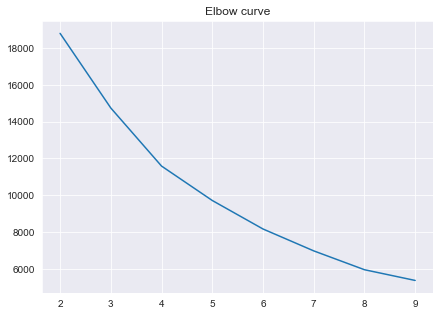

In [64]:
# ELBOW METHOD # 

# Data to run in the loop 
X = cluster_data_scaled
# create empty list to store SSEs for different k means clustering
SSE = []

# for loop runs on range between 2 and 10
for k in range(2, 10):
    # set up k means for each k between 2 and 10 
    kmeans = cluster.KMeans(n_clusters=k)
    # fit k means in data
    kmeans.fit(X)
    # append SSE values into empty list 
    SSE.append(kmeans.inertia_)

# set up elbow graph 
fig = plt.figure(figsize=(7, 5))
# plot values
plt.plot(range(2, 10), SSE)
# add grid
plt.grid(True)
# add title
plt.title('Elbow curve')

In this case, I am selecting k = 6

**Perform K-means clustering** 

In [65]:
# set up clustering analysis with k=5
k6 = cluster.KMeans(n_clusters=6)
k6

KMeans(n_clusters=6)

In [66]:
# fit clustering model on dataset created for clustering
np.random.seed(1234)
k6cl = k6.fit(cluster_data_scaled)

In [67]:
#check labels
labels=k6cl.labels_

labels

array([5, 5, 5, ..., 5, 5, 0], dtype=int32)

In [68]:
# count how many observations each cluster has. 
labels_tb = pd.DataFrame(joined.groupby(k6cl.labels_).size())

#rename column
labels_tb.rename(columns={0:'No Customers per Cluster'}, inplace=True)

labels_tb


,No Customers per Cluster
0,2365
1,135
2,1
3,5
4,7
5,1815


In [69]:
#create table with mean values per cluster
table_of_means=joined.groupby(k6cl.labels_).mean()
#add average spend per order by dividind average total spending by average n of orders placed
table_of_means['average_spend_order']=\
                    table_of_means['total_spending']/table_of_means['total_orders_placed']

In [70]:
# look at mean of the clusters 

# .T transpose the table to make it easier to look at
table_of_means.T

,0,1,2,3,4,5
total_quantity,432.764482,8337.422222,60.00,92827.4000,35328.571429,1128.405510
total_spending,689.554086,13651.327778,649.50,192103.8540,59766.425714,1906.356221
total_cancelled_orders,0.506131,22.592593,2.00,20.6000,104.571429,2.008264
total_orders_placed,43.689641,462.866667,5.00,1013.4000,4286.428571,113.318457
average_price_of_items,4.518666,4.033785,8055.78,6.3574,3.841534,3.821448
days_as_customer,162.010148,460.911111,66.00,479.6000,641.857143,400.126722
average_spend_order,15.783011,29.493003,129.90,189.5637,13.943175,16.822998


**Characterise the Clusters**

K-Means 4,328 observations contained in the dataset into 6 clusters. From the labels table it is possible to observe that the majority of observations are contained in cluster 1 and 4, while the rest are mainly contained in cluster 0. 

Looking at the mean of each cluster, the customers can be divided into three main segments.

1. **"The Frequent Cancellers"**: Cluster 1 customers have been with the site for close to 1.5 years and generally tend to buy a cheaper but a lot of items in one order and have a high propensity to cancel their orders.
2. **"The New-comers"**: Cluster 0 customers are relatively new to the site (less than 6 months) and tend to buy low priced items in a smaller budget with lesser propensity to cancel their ordered
3. **"The Stable Shoppers"**: Cluster 5 customers have been in the system for over 1 year and tend to display steady behavior by buying lower priced items within a smaller-priced overall order and have a lesses propensity to return items.

Based on the overall analysis, it is evident that further analysis on each cluster would be needed in addition to more data.

### Supervised Prediction using  Regression Analysis

Another important goal of a Online Retail store is to predict the number of orders placed by each customer for stock-keeping, recommendations, offers, etc.. Toward addressing this problem, I am using linear regession to predict the order pattern for customers.

As a first step, I created a baseline regression model. Then, I improved the the baseline model by scaling the predictive variables and by adding a categorical predictor. Thirdly, I used the random forest algorithm to further improve the model. Lastly, I assess the peformance of each regression model with and without cross-validation.

Linear regression aims at finding linear relationships between two or more continuous variables. A multiple linear regression model can be summarised by the following equation:

**y = β0 + β1x1 + β2x2 + ··· βkxk + ε**
where:

y is the predicted variable
β0 is the y-intercept of the equation
β1, β2,..., βk are the coefficient of the predictive variables
x1, x2,...,xk are the predictive variables
ε is the random error factor

In [71]:
# recall data for regression 
joined.head()

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,country_of_origin,average_price_of_items,days_as_customer
CustomerID,,,,,,,
12346.0,0,0.00,1,2,United Kingdom,1.040000,327.0
12347.0,2458,4310.00,0,182,Iceland,2.644011,517.0
12348.0,2341,1797.24,0,31,Finland,5.764839,359.0
12349.0,631,1757.55,0,73,Italy,8.289041,20.0
12350.0,197,334.40,0,17,Norway,3.841176,312.0


**Baseline Model**

My first model is a "baseline" that aims at predicting the number of total orders placed by a customer from:

- their total numer of orders cancelled
- the average price of products purchased
- the total quantity of items purchased.

In [72]:
#regression model 
m1_baseline = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + total_quantity',\
            joined).fit()

m1_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.432
Model:                             OLS   Adj. R-squared:                  0.432
Method:                  Least Squares   F-statistic:                     1097.
Date:                 Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                         16:56:14   Log-Likelihood:                -28517.
No. Observations:                 4328   AIC:                         5.704e+04
Df Residuals:                     4324   BIC:                         5.707e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 46.7812      2.804     16.686      0.000      41.285      52.278
total_cancelled_orders    16.1972      0.396     40.880      0.000      15.420      16.974
average_price_of_items    -0.0141      0.021     -0.669      0.504      -0.056       0.027
total_quantity             0.0129      0.001     20.695      0.000       0.012       0.014
==============================================================================
Omnibus:                     7904.201   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24238783.825
Skew:                          12.984   Prob(JB):                         0.00
Kurtosis:                     368.700   Cond. No.                     5.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Baseline Model Explaination**

From the summary of the baseline model I can infer that:

- When total cancelled orders, average price of items, and total quantity is 0, total orders amount to 46.8.
- Average price of items is negatively associated with number of orders. This means that, as the average price of items purchased increases, the number of orders placed decreases.
- The model has a R squared value of 0.432. This means that the model explains 43.2% of the total variation in "number of orders". R squared is also used as a measure of performance of a regression and it will be used later to compare the baseline model to the other models created.

**Scaled Baseline Model**

The first improvement I want to implement to the baseline model, is to scale the predictive variables. This step is advisable becasue the three variables are expressed in three different units (i.e. number of orders, GBP and number of items). Scaling the variables makes sure that they are all centred around 0 and will have the same standard deviation.

In [73]:
# Scale the predicting variables because they are on different scales
# (the first one is in orders, and the second one is in pounds.)

# create a list that includes the columns to scale
cols = ['total_cancelled_orders', 'average_price_of_items', 'total_quantity']

#scale columns by subtracting mean and dividing by standard deviation
scaled_for_reg = pd.DataFrame(scale(joined[cols]),
                   index=joined.index,
                   columns=cols)

#add column with variable to predict 
scaled_for_reg['total_orders_placed'] = joined['total_orders_placed']

#this is the second model with the scaled columns.
m2_scaled = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + total_quantity',\
            scaled_for_reg).fit()

m2_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.432
Model:                             OLS   Adj. R-squared:                  0.432
Method:                  Least Squares   F-statistic:                     1097.
Date:                 Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                         16:56:14   Log-Likelihood:                -28517.
No. Observations:                 4328   AIC:                         5.704e+04
Df Residuals:                     4324   BIC:                         5.707e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 93.9378      2.675     35.116      0.000      88.693      99.182
total_cancelled_orders   119.1708      2.915     40.880      0.000     113.456     124.886
average_price_of_items    -1.7888      2.675     -0.669      0.504      -7.033       3.456
total_quantity            60.3286      2.915     20.695      0.000      54.613      66.044
==============================================================================
Omnibus:                     7904.201   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24238783.825
Skew:                          12.984   Prob(JB):                         0.00
Kurtosis:                     368.700   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Scaled Baseline Model Explaination**

From the summary of the scaled, improved model I can infer that:

- When total cancelled orders, average price of items, and total quantity is 0, total orders amount to 93.9.
- Average price of items is still negatively associated with number of orders. In the scaled model, this association is slightly stronger, in fact, for a positive change of average price of items, the number of orders decreases by 1.78 orders as opposed to 0.01.
- The model's R squared has not changed.

**Predictive Checking**

Since the aim of a regression model is to predict future number of orders places by a potential customer, it is important to look at the distribution of actual "total_orders_placed" VS the distribution of "total_orders_placed" predicted by the baseline model, and by the scaled baseline model.

To do so, I am using Seaborn's kdeplot() fuction which gives a smooth estimate of the distribution using kernel density estimation. Using kdeplot() I plotted the distribution of actual values, the distribution of the values predicted by the baseline model, and the distribution of the values predicted by the scaled model. Finally, I have plotted the three curves in the same graph to assess if the regression models are "picking up" the overall shape of the data.

*Distribution of Actual Values*

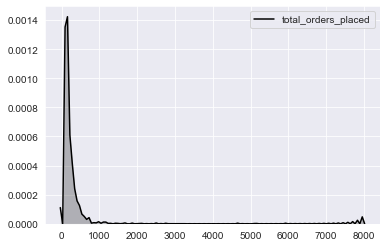

In [74]:
#Distribution of actual number of oders
sns.kdeplot(joined['total_orders_placed'], shade=True, color = 'black')

*Distribution of Baseline Model Fitted Values*

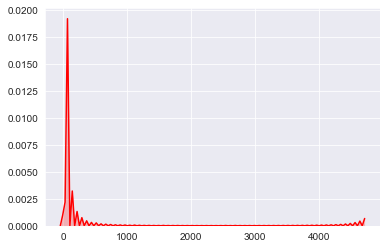

In [75]:
#distribution of predicted numbers of orders
sns.kdeplot(m1_baseline.fittedvalues, shade=True, color='red')

*Distribution of Scaled Model Fitted Values*

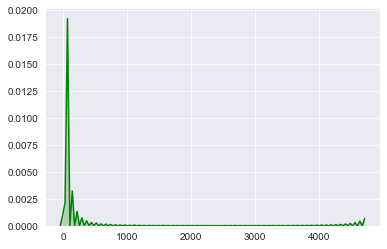

In [76]:
#distribution of predicted numbers of orders second prediction 
sns.kdeplot(m2_scaled.fittedvalues, shade=True, color='green')

***Comparison of Distributions***

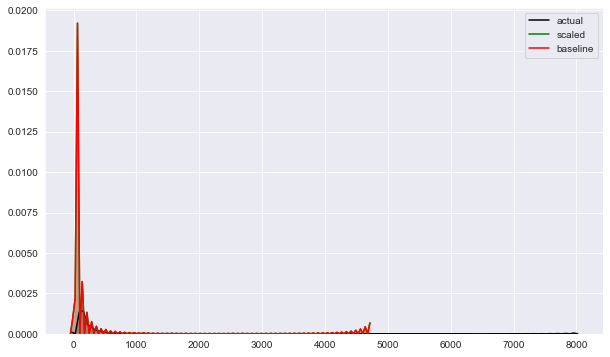

In [77]:
#make put all in the same graph
f, ax = plt.subplots(1, figsize=(10, 6))
sns.kdeplot(joined['total_orders_placed'], shade=True, ax=ax, label='actual', color= 'black')
sns.kdeplot(m2_scaled.fittedvalues, shade=True, ax=ax, label='scaled', color = 'green')
sns.kdeplot(m1_baseline.fittedvalues, shade=True, ax=ax, label='baseline', color = 'red')
plt.show()

From the graph above, it is possible to understand that scaled and baseline model's fitted values (red and green graphs) have the same distribution and that they one captures the overall shape of the actual values (black graph), however the values are overestimated by the regression models.

To get a better distribution match, I am going to further improve the model by adding a categorical variable as a predictor in the new model.

**Adding a Categorial Variable**

Categorical variables can be added to regression models as dummy variables. Python's sm.ols() automatically recognise string variables and treats them as categorical.

Here, I decided to create a variable "continent_of_origin" and use it as a predictor in the regression model. Since the majority of customers are based in europe, I have decided to sub-divide european countries according to european area (i.e. north, south, east and west europe). 

In [78]:
# add "country_of_origin" variable to scaled dataset
scaled_for_reg['country_of_origin'] = joined['country_of_origin']

In [79]:
#create lists of continents. 
north_europe=['Iceland','Norway','Denmark','Sweden','Finland','Lithuania',\
             'EIRE','Channel Islands','United Kingdom']
east_europe=['Poland','Czech Republic']
south_europe=['Greece','Italy', 'Malta','Spain','Portugal',]
west_europe=['Switzerland', 'Austria','Belgium', 'Netherlands']
asia=['Cyprus','Bahrain','Israel','Saudi Arabia','United Arab Emirates','Singapore',\
      'Japan','Lebanon']
australia=['Australia']
africa=['RSA']
america=['USA','Brazil','Canada']

In [80]:
# Code country of origin by continent 

# Create a function that will assign "unspecified"to all variables unless
# The content of the row is in the list declared above. 

# Declare function
def continent(row):
    #assing all rows to unspecified 
    value = "unspecified"
    # but, if country is contained in the list north_europe, 
    if row['country_of_origin'] in north_europe:
        # give value europe and so on... 
        value = 'north europe'
    if row['country_of_origin'] in south_europe: 
        value = 'south europe'
    if row['country_of_origin'] in east_europe:
        value = 'east europe'
    if row['country_of_origin'] in west_europe:
        value = 'west europe'
    if row['country_of_origin'] in asia:
        value ='asia'
    if row['country_of_origin'] in australia:
        value='australia'
    if row['country_of_origin'] in africa:
        value = 'africa'
    if row['country_of_origin'] in america:
        value= 'america'
    #at the end, return value
    return value

# Create a new column 'continent_of_origin' and apply the function. 
scaled_for_reg['continent_of_origin'] = scaled_for_reg.apply(continent, axis=1)

In [81]:
scaled_for_reg.head()

,total_cancelled_orders,average_price_of_items,total_quantity,total_orders_placed,country_of_origin,continent_of_origin
CustomerID,,,,,,
12346.0,-0.138209,-0.039807,-0.241593,2,United Kingdom,north europe
12347.0,-0.274125,-0.027119,0.282003,182,Iceland,north europe
12348.0,-0.274125,-0.002433,0.257080,31,Finland,north europe
12349.0,-0.274125,0.017533,-0.107179,73,Italy,south europe
12350.0,-0.274125,-0.017650,-0.199628,17,Norway,north europe


In [82]:
# create new model
m3_improved = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + continent_of_origin + total_quantity', scaled_for_reg ).fit()
# look at model summary
m3_improved.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.435
Model:                             OLS   Adj. R-squared:                  0.434
Method:                  Least Squares   F-statistic:                     302.5
Date:                 Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                         16:56:16   Log-Likelihood:                -28505.
No. Observations:                 4328   AIC:                         5.703e+04
Df Residuals:                     4316   BIC:                         5.711e+04
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                             100.9845    175.679      0.575      0.565    -243.437     445.406
continent_of_origin[T.america]       -209.7612    185.246     -1.132      0.258    -572.938     153.416
continent_of_origin[T.asia]           -43.6005    179.159     -0.243      0.808    -394.844     307.644
continent_of_origin[T.australia]     -160.7937    185.255     -0.868      0.385    -523.989     202.402
continent_of_origin[T.east europe]    -45.5345    187.809     -0.242      0.808    -413.737     322.668
continent_of_origin[T.north europe]    -4.7807    175.701     -0.027      0.978    -349.246     339.684
continent_of_origin[T.south europe]   -15.3724    177.005     -0.087      0.931    -362.392     331.648
continent_of_origin[T.unspecified]    -23.6991    176.153     -0.135      0.893    -369.050     321.652
continent_of_origin[T.west europe]    -22.3453    177.103     -0.126      0.900    -369.557     324.867
total_cancelled_orders                120.0132      2.923     41.060      0.000     114.283     125.744
average_price_of_items                 -1.8155      2.670     -0.680      0.497      -7.051       3.420
total_quantity                         60.6905      2.931     20.704      0.000      54.944      66.437
==============================================================================
Omnibus:                     7913.861   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24157473.530
Skew:                          13.023   Prob(JB):                         0.00
Kurtosis:                     368.078   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Categorial Model Explaination**

From the summary of the model containing country of origin as a predictor, I can infer that:

- The R squared value increases to 0.435
- Coefficients suggest that being from the American continent, decreases the most the number of orders placed. While being from north europe decreases it the least, suggesting that the latter, brings the most customers (as observed above).

***Predictive Checking***

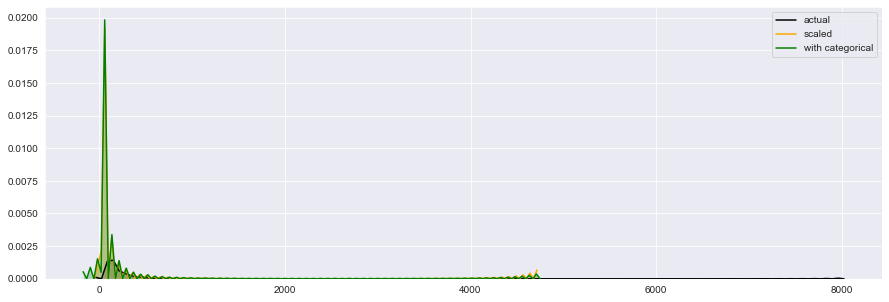

In [83]:
# graph baseline, scaled and categorical model
f, ax = plt.subplots(1, figsize=(15, 5))
# first plot 
sns.kdeplot(joined['total_orders_placed'], shade=True, ax=ax,\
            label='actual', color = 'black')
# second plot 
sns.kdeplot(m2_scaled.fittedvalues, shade=True, ax=ax, \
            label='scaled', color= 'orange')
# third plot 
sns.kdeplot(m3_improved.fittedvalues, shade=True, ax=ax,\
            label='with categorical', color='green')

plt.show()

The latest model, does not seem to improve the prediction, as the distribution curve has remained unchanged from the one of the scaled model.

Next, I will explore the models' performance, to have a better idea of their predictive power.

### Model performance
To assess the model performance, I will compare the R squared, Mean Square Error (MSE), and Mean Absolute Error (MAE) of the baseline model with the measures of the latest model.

The MAE measures the average error in absolute terms of a set of forecasts. The MSE measures the average of the squares of the error in a set of forecasts. Along with R squared, MAE and MSE are generally used as a measure of model performance.

In [84]:
#R^2
r2 = pd.Series({'Baseline Model': metrics.r2_score(joined['total_orders_placed'],
                                              m1_baseline.fittedvalues),
                'Latest Model': metrics.r2_score(scaled_for_reg['total_orders_placed'],
                                              m3_improved.fittedvalues)})
r2

Baseline Model    0.432277
Latest Model      0.435298
dtype: float64

In [85]:
# MSE
mse = pd.Series({'Baseline Model': metrics.mean_squared_error(joined['total_orders_placed'],
                                                        m1_baseline.fittedvalues),
                 'Latest Model': metrics.mean_squared_error(scaled_for_reg['total_orders_placed'],
                                                         m3_improved.fittedvalues)})

In [86]:
# MAE
# taking the MAE between actual values and the values forecasted by the baseline model
mae = pd.Series({'Baseline Model': metrics.mean_absolute_error(joined['total_orders_placed'],
                                                         m1_baseline.fittedvalues),
                 #taking the MAE between actual values and the values forecasted by m3 model
                 'Latest Model': metrics.mean_absolute_error(scaled_for_reg['total_orders_placed'],
                                                          m3_improved.fittedvalues)})

In [87]:
perf = pd.DataFrame({'MAE': mae,
                     'MSE': mse,
                     'R^2': r2})
perf

,MAE,MSE,R^2
Baseline Model,67.967766,30941.743636,0.432277
Latest Model,68.615029,30777.065205,0.435298


From the comparison of MAE, MSE and R squared, It is important to note that R squared and MSE slightly improved from the baseline model and latest model, while MAE resulted higher in the latest model.

Since the aim of the regression model is to make predictions, it is appropriate to assess the validity of the model with cross-validation. Cross-validation is a validation technique for assessing how a model will perfom on a different and independent data set. The first step to cross-validation is to split the data set into train set and test set. The forecasting model is then trained on the train set and consequently validated on the test set.

### Cross-Validation

**Split the Data into Train and Test set**

In [88]:
# Split dataset into train (80%) and test set (20%)
# names of predictive variables
cols = ['total_cancelled_orders', 'average_price_of_items',\
            'total_quantity'] 

# create test and train sets 
x_train, x_test, y_train, y_test =\
                    model_selection.train_test_split(scaled_for_reg[cols], 
                                                    joined['total_orders_placed'],
                                                    test_size=0.8)

**Train Model on Train Set**

In [89]:
# Train data on train set
# f is a variable that includes the regression equation
f = 'total_orders_placed ~ total_cancelled_orders + average_price_of_items + total_quantity'

# this is the regression model
m1_train = sm.ols(f, x_train.assign(total_orders_placed=y_train)).fit()

**Compare Parameters and R Squared**

In [90]:
# create data frame containin the parameters of full set and of train set
pd.DataFrame({'Full Dataset': m1_baseline.params,
              'Train Set': m1_train.params})

,Full Dataset,Train Set
Intercept,46.781173,92.088390
total_cancelled_orders,16.197225,79.071384
average_price_of_items,-0.014149,-220.155505
total_quantity,0.012851,93.698998


In [91]:
# explore r quared of full data set and of train set 
pd.Series({'Full Dataset': m1_baseline.rsquared,
           'Train Set': m1_train.rsquared})

Full Dataset    0.432277
Train Set       0.384786
dtype: float64

**Predict Test Set Values and Explore R Squared**

In [92]:
# make predictions on test set. 
test_prediction = m1_train.params['Intercept'] + \
            x_test.dot(m1_train.params.drop('Intercept'))

#create a series with the r squared of baseline, train set data and test set data
pd.Series({'0-Full Dataset': m1_baseline.rsquared,
           '1-Train Set': m1_train.rsquared,
           '2-Test Set': metrics.r2_score(y_test,
                                        test_prediction)})

0-Full Dataset    0.432277
1-Train Set       0.384786
2-Test Set       -0.658937
dtype: float64

- From the comparisons of R Squared values of the full data, train data set and test data, it is possible to note that R squared increases from the full data to the train data, but it decreases, and becomes negative, for the test data.
- This is an example of "overfitting". Overfitting happens when a model describes the random error in the data rather than the relationships between variables. 
- This means that the model created is a good fit to make preditions in the specific dataset used for analysis (R squared is 0.43), however it has no forecasting power over any other independent data set (R squared is -0.37).

### Random Forest for Prediction

The Random Forest is a machine learning algorithm that is used on classification or regression problems. It is one of the most popularly used algorithms because of its simplicity and effectiveness. 

In [93]:
# run random forest regression. we can fit and predict in the same line
m4_RandomF = RandomForestRegressor().fit(joined[cols], joined['total_orders_placed'])\
                            .predict(joined[cols])

**Assess Performance**

In [94]:
# examine MAE MSE and R suqared of FR 
rf = pd.Series({'R^2': metrics.r2_score(joined['total_orders_placed'], m4_RandomF), 
                'MSE': metrics.mean_squared_error(joined['total_orders_placed'], m4_RandomF),
                'MAE': metrics.mean_absolute_error(joined['total_orders_placed'], m4_RandomF)})

# add RF performance indicators to the table of baseline and m3 model
pd.concat([perf, 
           pd.DataFrame({'Random Forest': rf}).T])

,MAE,MSE,R^2
Baseline Model,67.967766,30941.743636,0.432277
Latest Model,68.615029,30777.065205,0.435298
Random Forest,21.257589,5248.118131,0.903707


- From the table above, it is important to note that the Random Forest regressor performs considerably better than the baseline model and the latest model with scaled variables and a categorical predictor.
- Its MAE went from 68 to 22, MSE went from 30,000 to 6,000 and finally, its R squared value is 0.90, meaning that the model picks up almost 90% of the variation of the predicted variable.

**Random Forest Cross Validated**

Just as I did for the previous model, I am going to assess the performace of the Random Forest model with cross-validation to see if this model can be used to make predictions.

In [95]:
# previously the model was fitted on the same dataset where the predictions were made.
# in this case, we are making the predictions on the text set

# random forest cross validation. 
m4_cv = RandomForestRegressor().fit(x_train, y_train).predict(x_test)

In [96]:
# get MSE, MAE e R2 for cross validated RF
rf_cv = pd.Series({'R^2': metrics.r2_score(y_test, m4_cv), 
                'MSE': metrics.mean_squared_error(y_test, m4_cv),
                'MAE': metrics.mean_absolute_error(y_test, m4_cv)})
pd.concat([perf, 
           pd.DataFrame({'RF': rf}).T,
           pd.DataFrame({'RF-CV': rf_cv}).T])

,MAE,MSE,R^2
Baseline Model,67.967766,30941.743636,0.432277
Latest Model,68.615029,30777.065205,0.435298
RF,21.257589,5248.118131,0.903707
RF-CV,61.167320,37741.109471,0.326618


- As expected, the cross-validated Random Forest regressor performance are much worst compared to the non-cross-validated performance measures. 
- This once again, is a sign of overfitting and suggests that the regression model has little predictive power over an independent dataset.

## Conclusion and Recomendations 

In conlusion, this project was carried out using a dataset containing 541,909 data points corresponding to e-commerce transactions of an online UK retailer. The aim was to segment customers and to create a regression model that could forecast the number of orders placed by each customer.

To carry out the project, I first pre-processed the data by inspecting it, transforming existing variables, creating new variables, dealing with missing values, grouping the data at customer level and finally performing descriptive statistics and data visualization. The second step was then to segment customers into categories, to do so, I have used k-means cluster analysis. From this, I was able to divide customers into three main classes:

1. The Frequent Cancellers
2. The New-comers
3. The Stable Shoppers

After performing clustering analysis, I have modeled a multiple linear regression with the aim of forecasting the number of orders placed by each customers. I first create a baseline model, which was then improved by scaling the predictive variables and by adding a categorical variable as predictor. Model performance was assessed with and without cross-validation and this showed strong signs of overfitting. To overcome this problem and to improve the predictive power of the model, I have used the Random Forest algorithm and assessed its performance with and without cross-validation. Once again, the performance indicators suggested that the regression model has little predictive power over an independent dataset.

To solve this problem, for future research it is advisable to join the current dataset with information about the demographics and shopping habits of each customer. This will add valuable information that can be used by the clustering algorithm to further segment customers and by the regression model to spot meaningful relationships within the variables in the data.